In [1]:
# importing necessary librarise

import numpy as np
import gym
import random
from tensorflow.keras import Sequential
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.activations import relu, linear

In [2]:
# Defining a Class for Deep Q learning

class DQN:

    # initialize using the action and state size
    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

    # building and compiling a neural network of n (here n=3) layers 
    def build_model(self):
        
        model = Sequential([
            Dense(150, input_dim=self.state_space, activation=relu),
            Dense(120, activation=relu),
            Dense(self.action_space, activation=linear)])

        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model
    
    #saving a model
    def save_model(self):
        self.model.save('Cartpole-model')

    # creating checkpoints (adding in memory)
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # predicting the next action from current state
    def act(self, state):

        # checking for exploration or exploitation
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])


    def replay(self):

        # if batchsize is greater is less than memory size then exit
        if len(self.memory) < self.batch_size:
            return

        
        # fetching data from minibatch and assigning to states, actions, rewards, next_states and dones
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Remove single-dimensional entries from states and next_states.
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        
        # setting target values
        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        # training the model
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        
        # reducing the epsilon to reduce exploitation
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [3]:
# Training Deep q-learning network

def train_dqn(episode):

    loss = []
    
    # getting the agent from DQN class (environment)
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    
    #iterate for each episode
    for e in range(episode):
        
        # getting a state by reseting the environment
        state = env.reset()
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 3000
        
        #for all states in each episode
        for i in range(max_steps):
            # getting the action from environment at a particular state
            action = agent.act(state)
            env.render()
            
            # calculating the reward and next state for a selected action
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            
            # adding the agents learning to memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Average score of last 100 episode
        is_solved = np.mean(loss[-100:])
        if is_solved > 50:
            print('\n Task Completed! \n')
            agent.save_model()
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss

In [4]:
# Creating an environment of Cartpole-v0

env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

Box(4,)
Discrete(2)
episode: 0/400, score: 16.0
Average over last 100 episode: 16.00 

episode: 1/400, score: 15.0
Average over last 100 episode: 15.50 

episode: 2/400, score: 15.0
Average over last 100 episode: 15.33 

episode: 3/400, score: 19.0
Average over last 100 episode: 16.25 

episode: 4/400, score: 15.0
Average over last 100 episode: 16.00 

episode: 5/400, score: 17.0
Average over last 100 episode: 16.17 

episode: 6/400, score: 10.0
Average over last 100 episode: 15.29 

episode: 7/400, score: 14.0
Average over last 100 episode: 15.12 

episode: 8/400, score: 20.0
Average over last 100 episode: 15.67 

episode: 9/400, score: 21.0
Average over last 100 episode: 16.20 

episode: 10/400, score: 8.0
Average over last 100 episode: 15.45 

episode: 11/400, score: 27.0
Average over last 100 episode: 16.42 

episode: 12/400, score: 14.0
Average over last 100 episode: 16.23 

episode: 13/400, score: 10.0
Average over last 100 episode: 15.79 

episode: 14/400, score: 11.0
Average ov

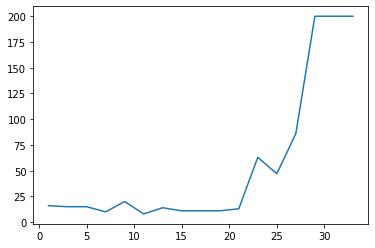

In [5]:
# print the output and plot the graph 

print(env.observation_space)
print(env.action_space)
episodes = 400
loss = train_dqn(episodes)
plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
plt.show()